## Advanced Lane Finding

//TODO
* Camera calibration (DONE)
* distorion correction (DONE)
* color/gradient threshold (DONE)
* Perspective transform (DONE)
* Detect lane lines
* Calculate curvature

In [1]:
# import all needed lib here
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random
%matplotlib inline

In [2]:
# Camera calibration
# Read all in of calibration images
def generate_obj_image_points(root_path):
    images = glob.glob(root_path+'/calibration*.jpg')

    #prepare object point
    nx = 9
    ny = 6
    objp = np.zeros((ny*nx, 3), np.float32)
    #tricky here to get x,y coordinate since z is zero we don't care
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # get x,y coordinate

    # arrays of object and image points
    objpoints = []
    imgpoints = []

    for image_path in images:
        img = mpimg.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)                
    
    return objpoints, imgpoints

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist   

def display_2_images(img1, img2):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
  f.tight_layout()
  ax1.imshow(img1)
  ax1.set_title('Original Image', fontsize=50)
  ax2.imshow(img2)
  ax2.set_title('Dest Image', fontsize=50)
  plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def display_color_gray(color, gray):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
  f.tight_layout()
  ax1.imshow(color)
  ax1.set_title('Original Image', fontsize=50)
  ax2.imshow(gray, cmap='gray')
  ax2.set_title('Dest Image', fontsize=50)
  plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

objpoints,imgpoints = generate_obj_image_points('./camera_cal')

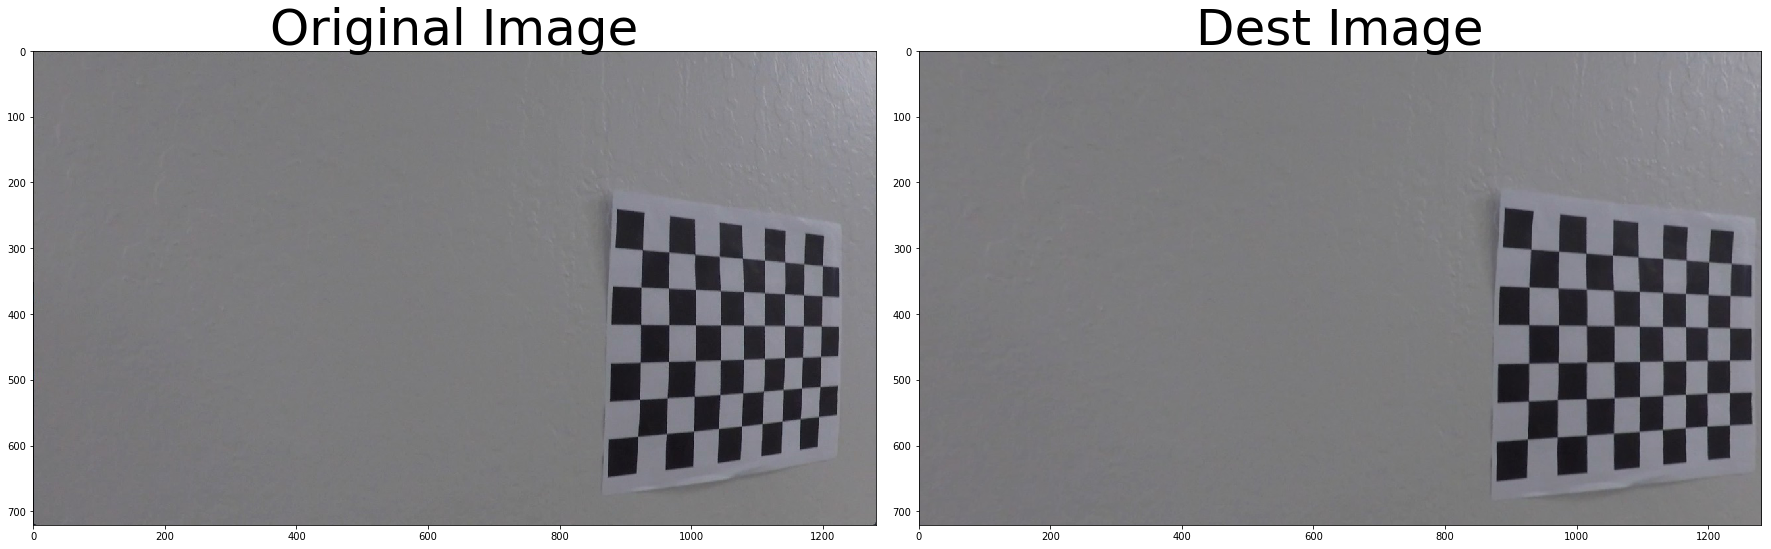

In [3]:
images = glob.glob('./camera_cal/calibration*.jpg')
index = random.randint(0,len(images))
img_test = mpimg.imread(images[index])
img_calibrate = cal_undistort(img_test, objpoints, imgpoints)
display_2_images(img_test, img_calibrate)

### Color and Gradient threshold

In [ ]:
def mask_with_threshold(input_v, thresh):
    # create mask and apply threshold
    mask = np.zeros_like(input_v)
    mask[(input_v >= thresh[0]) & (input_v <= thresh[1])] = 1
    return mask

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = None
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return mask_with_threshold(scaled_sobel, thresh)
    
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # magnitude ==> sqrt(x^2 + y^2)
    mag = np.sqrt(sobelx**2 + sobely**2)
    # scale to 8 bit
    scaled_mag = np.uint8(255*mag/np.max(mag))
    return mask_with_threshold(scaled_mag, thresh)
    
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)): 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    arc_v = np.arctan2(abs_sobely, abs_sobelx)
    return mask_with_threshold(arc_v, thresh)

def color_threshold(img, channel, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel_v = None
    if channel == 'R':
        channel_v = img[:,:,0]
    elif channel == 'G':        
        channel_v = img[:,:,1]
    elif channel == 'B':        
        channel_v = img[:,:,2]
    elif channel == 'H':
        channel_v = hls[:,:,0]
    elif channel == 'L':        
        channel_v = hls[:,:,1]
    elif channel == 'S':        
        channel_v = hls[:,:,2]
        
    return mask_with_threshold(channel_v, thresh)

def combine_gradient_threshold(img):
    # Apply each of the thresholding functions
    ksize = 3
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(40*np.pi/180, 75*np.pi/180)) # 40 to 75 degree
    
    #combined all above threshold (gradx & grady) or (mag_binary and dir_binary)
    mask = np.zeros_like(dir_binary)
    mask[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return mask

def combine_color_threshold(img):
    r_channel = color_threshold(img, 'R', thresh=(200,255))
    s_channel = color_threshold(img, 'S', thresh=(200,255))    
    
    #combined all above threshold (gradx & grady) or (mag_binary and dir_binary)
    mask = np.zeros_like(s_channel)
    mask[(r_channel == 1) | (s_channel == 1) ] = 1
    return mask

#### Combine Sobelx, Sobely, Magnitude and Direction of gradient

Let visualize the comination 

In [ ]:
images = glob.glob('./test_images/*.jpg')
for image in images[:3]: 
    #test sample imgage
    sample_image = mpimg.imread(image)
    binary = combine_gradient_threshold(sample_image)
    display_color_gray(sample_image, binary)


#### Combine Color threshold

In [ ]:
#test sample imgage
sample_image = mpimg.imread('./test_images/test5.jpg')
binary = color_threshold(sample_image, 'R', thresh=(200,255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sample_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Dest Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#test another sample imgage
sample_image = mpimg.imread('./test_images/test5.jpg')
binary = color_threshold(sample_image, 'S', thresh=(150,255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sample_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Dest Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#test another sample imgage
sample_image = mpimg.imread('./test_images/test5.jpg')
binary = combine_color_threshold(sample_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sample_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Dest Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Let combine 

And at the end we will have our pipeline to use be noted with visualize, if specify, we can see the sample pictures.

In [ ]:
def pipeline(img, visualize=False):
    #combine both gradient and color    
    binary_gradient = combine_gradient_threshold(img)
    binary_color = combine_color_threshold(img)
    
    #merge 
    mask = np.zeros_like(binary_color)
    mask[(binary_gradient == 1) | (binary_color == 1)] = 1
    
    if visualize:
        color_binary = np.uint8(np.dstack(( np.zeros_like(binary_color), binary_gradient, binary_color)) * 255)
        
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('original Image', fontsize=50)
        ax2.imshow(color_binary)
        ax2.set_title('stack Image', fontsize=50)
        ax3.imshow(mask, cmap='gray')
        ax3.set_title('Binary Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    
    return mask

images = glob.glob('./test_images/*.jpg')
for image in images[:3]:    
    binary = pipeline(mpimg.imread(image), visualize=True)  


### Perspective Transform

In [ ]:
#Unwarp img with offset of 100, that can be changed  
def warp(img):
    #define src and dst
    #     src = np.float32([[200. , 720, ],[453. , 547.],[835. , 547. ],[1100. , 720. ]])
    #     dst = np.float32([[320., 720],[320. , 590.4],[920., 590.4],[920. , 720]])
    src = np.float32([[570,468],  [714,468], [1106,720], [207,720]])
    bottom_left = [320,720] 
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]
    dst = np.float32([top_left,top_right,bottom_right, bottom_left])
    img_size = (img.shape[1], img.shape[0])
    # plot ploylines on img to see
    # pts = src.reshape((-1,1,2)).astype(np.int32)
    # cv2.polylines(img,[pts],True,(0,255,255), 5)
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(apply_treshhold, M, img_size, flags = cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return warped, M 

In [ ]:
images = glob.glob('./test_images/*.jpg')

for image in images[:3]:
    img = mpimg.imread(image)
    img_undistort = cal_undistort(img, objpoints, imgpoints)
    apply_treshhold = pipeline(img_undistort, visualize=False)
    warped, M = warp(apply_treshhold)
    display_color_gray(img, warped)

### Detect the lines

In [ ]:
def slicing_window(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255  
    
    plt.plot(histogram)
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = binary_warped.shape[0]//nwindows
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
      # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Visualize it
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

In [ ]:
images = glob.glob('./test_images/*.jpg')

for image in images[0:1]:
    img = mpimg.imread(image)
    img_undistort = cal_undistort(img, objpoints, imgpoints)
    apply_treshhold = pipeline(img_undistort, visualize=False)
    warped, M = warp(apply_treshhold)
#     display_color_gray(img, warped)
    slicing_window(warped)